# Load injection - Locust

This notebook studies the impact of clients doing requests for CoAP servers.

In [1]:
import os
cur_dir=os.getcwd() # save current directory to save the generated CSV files

%cd ../../..
%pwd

/home/jovyan/work


'/home/jovyan/work'

## Introduction

This notebook uses the 05-locust-g5k-iotlab.ipynb to evaluate the impact on the response time of different load injections. For that, we vary the number of **users** performing requests to CoAP servers, keeping the other parameters fixed.

Similarly to the 04-load-injection notebook, it is divided in 3 main parts.

- **Description**: creates a data frame containing the description of the different parameters of your experiment. In our case the different number of **users** in the system.
- **Running**: Reads the data frame with the description the experiment and runs each experiment. It uses papermill to call the 05-locust-g5k-iotlab.ipynb notebook with the correct parameters. Also, creates a data frame with the results.
- **Analysis**: Finally, read the output from the running phase and performs the data analysis.

Note that you can run each part **independently**. It only depends on running the first cell of this notebook to set the cur_dir properly.

## Description

Detailing the parameters used in the different experiment runs.

In [2]:
import pandas
import io
import uuid
import datetime

experiments=io.StringIO("""
firmware,iotlab_nodes,g5k_nodes,duration,users
contikimac,4,1,300,1
contikimac,4,1,300,10
contikimac,4,1,300,15
contikimac,4,1,300,20
contikimac,4,1,300,50
""")

job_name="rsd-hackathon"

df = pandas.read_csv(experiments)

df['exp_id'] = [str(uuid.uuid4()) for _,_ in df.iterrows()]
df['date'] = str(datetime.date.today())
df['data_dir'] = ["data/raw/%s/%s" % (i['date'], i['exp_id']) for _,i in df.iterrows()]
df['notebook_dir'] = ["%s/%s" % (cur_dir, i['exp_id']) for _,i in df.iterrows()]
df['state'] = 'created'

df = df.sample(frac=1).reset_index(drop=True) # randomize test execution
df.to_csv("%s/experiment.csv" % cur_dir)
df

firmware  iotlab_nodes  g5k_nodes  duration  users  \
0  contikimac             4          1       300     15   
1  contikimac             4          1       300     20   
2  contikimac             4          1       300     10   
3  contikimac             4          1       300     50   
4  contikimac             4          1       300      1   

                                 exp_id        date  \
0  2aa671a0-e38b-4262-9653-678c1550a661  2021-09-09   
1  ba254b17-ebba-4161-9b7d-0270f20b8388  2021-09-09   
2  c5f78e8b-b5de-4bf9-8864-cb3beb3a7a5d  2021-09-09   
3  5eb75ab1-425c-492e-a777-3e13c44422d6  2021-09-09   
4  a440c1c6-3cf0-47e0-b5bb-5a53d028c0b8  2021-09-09   

                                            data_dir  \
0  data/raw/2021-09-09/2aa671a0-e38b-4262-9653-67...   
1  data/raw/2021-09-09/ba254b17-ebba-4161-9b7d-02...   
2  data/raw/2021-09-09/c5f78e8b-b5de-4bf9-8864-cb...   
3  data/raw/2021-09-09/5eb75ab1-425c-492e-a777-3e...   
4  data/raw/2021-09-09/a440c1c6-3cf0-47e0-b5bb-5a...   

                                        notebook_dir    state  
0  /home/jovyan/analysis/06-load-injection-locust...  created  
1  /home/jovyan/analysis/06-load-injection-locust...  created  
2  /home/jovyan/analysis/06-load-injection-locust...  created  
3  /home/jovyan/analysis/06-load-injection-locust...  created  
4  /home/jovyan/analysis/06-load-injection-locust...  created

## Running

In [3]:
import papermill as pm
import pathlib
import pandas

# read the description of the experiment
df = pandas.read_csv("%s/experiment.csv" % cur_dir)
for index, exp in df.iterrows():
    # run only recently created experiments
    if exp['state'] != 'created':
        continue

    print("Running experiment number: %d, ID: %s, firmware: %s, number of users: %d" % (index, exp['exp_id'], exp['firmware'], exp['users']))
    pathlib.Path(exp['notebook_dir']).mkdir(exist_ok=True, parents=True)

    pm.execute_notebook(
        'analysis/05-locust/05-locust-g5k-iotlab.ipynb',
        '%s/06-load-injection-locust-%d-%s.ipynb' % (exp['notebook_dir'], exp['users'], exp['exp_id']),
        cwd = "analysis/05-locust",  # going back to folder to execute notebook
        parameters = dict(
            output_dir = exp['data_dir'],
            er_image = "data/firmware/%s/er-example-server.iotlab-m3" % exp['firmware'],
            br_image = "data/firmware/%s/border-router.iotlab-m3" % exp['firmware'],
            free_resources = False if index < len(df.index) - 1 else True, #free resources in last experiment
            duration = exp['duration'],
            users = exp['users'],
            iotlab_nodes = exp['iotlab_nodes'],
            iotlab_site = 'grenoble',
            g5k_nodes = exp['g5k_nodes'],
        )
    )
    
    # change and save new state
    df.at[index, 'state'] = 'executed'
    df.to_csv("%s/experiment.csv" % cur_dir)


Running experiment number: 0, ID: 2aa671a0-e38b-4262-9653-678c1550a661, firmware: contikimac, number of users: 15


Executing:   0%|          | 0/54 [00:00<?, ?cell/s]

Running experiment number: 1, ID: ba254b17-ebba-4161-9b7d-0270f20b8388, firmware: contikimac, number of users: 20


Executing:   0%|          | 0/54 [00:00<?, ?cell/s]

Running experiment number: 2, ID: c5f78e8b-b5de-4bf9-8864-cb3beb3a7a5d, firmware: contikimac, number of users: 10


Executing:   0%|          | 0/54 [00:00<?, ?cell/s]

Running experiment number: 3, ID: 5eb75ab1-425c-492e-a777-3e13c44422d6, firmware: contikimac, number of users: 50


Executing:   0%|          | 0/54 [00:00<?, ?cell/s]

Running experiment number: 4, ID: a440c1c6-3cf0-47e0-b5bb-5a53d028c0b8, firmware: contikimac, number of users: 1


Executing:   0%|          | 0/54 [00:00<?, ?cell/s]

Parse and save results.

In [10]:
import pandas
import os.path

# where to save the results from experiment
results_filename = "%s/results.csv" % cur_dir
out = None
results_full_filename = "%s/results_full.csv" % cur_dir
out_full = None


# read the description of the experiment
df = pandas.read_csv("%s/experiment.csv" % cur_dir)
for index, exp in df.iterrows():
    if exp['state'] != 'executed':
        continue

    # read and save output of this test
    temp = pandas.read_csv(exp['data_dir'] + "/enoslib_stats.csv")
    temp['exp_id'] = exp['exp_id']
    temp['users'] = exp['users']
    out = pandas.concat([out, temp])
    
    temp = pandas.read_csv(exp['data_dir'] + "/enoslib_stats_history.csv")
    temp['exp_id'] = exp['exp_id']
    temp['users'] = exp['users']
    out_full = pandas.concat([out_full, temp])
    
out.to_csv(results_filename)
out_full.to_csv(results_full_filename)    

## Analysis

Read dataframe with the results of all experiments.

Locust already gives us aggregated results about main metrics. Let's use them.

In [2]:
%load_ext rpy2.ipython
import pandas

out = pandas.read_csv("%s/results.csv" % cur_dir)

out_full = pandas.read_csv("%s/results_full.csv" % cur_dir)
out_full['Type'] = out_full['Type'].fillna('') # Remove NaN from Type
out_full

Unnamed: 0   Timestamp  User Count        Type  \
0              0  1631198511           0               
1              1  1631198512           1               
2              2  1631198513           2               
3              3  1631198514           3  coapclient   
4              4  1631198514           3  coapclient   
...          ...         ...         ...         ...   
5353         594  1631200371           1               
5354         595  1631200372           0  coapclient   
5355         596  1631200372           0               
5356         597  1631200373           0  coapclient   
5357         598  1631200373           0               

                                               Name  Requests/s  Failures/s  \
0                                        Aggregated         0.0         0.0   
1                                        Aggregated         0.0         0.0   
2                                        Aggregated         0.0         0.0   
3     [2001:660:5307:3142::a172]:5683/sensors/gyros         0.0         0.0   
4     [2001:660:5307:3142::b679]:5683/sensors/gyros         0.0         0.0   
...                                             ...         ...         ...   
5353                                     Aggregated         0.9         0.0   
5354  [2001:660:5307:3142::b679]:5683/sensors/gyros         0.9         0.0   
5355                                     Aggregated         0.9         0.0   
5356  [2001:660:5307:3142::b679]:5683/sensors/gyros         0.9         0.0   
5357                                     Aggregated         0.9         0.0   

        50%    66%    75%  ...   100%  Total Request Count  \
0       NaN    NaN    NaN  ...    NaN                    0   
1       NaN    NaN    NaN  ...    NaN                    0   
2       NaN    NaN    NaN  ...    NaN                    0   
3      97.0   97.0   97.0  ...   97.0                    1   
4     220.0  220.0  220.0  ...  220.0                    2   
...     ...    ...    ...  ...    ...                  ...   
5353  100.0  100.0  110.0  ...  220.0                  270   
5354  100.0  100.0  110.0  ...  220.0                  271   
5355  100.0  100.0  110.0  ...  220.0                  271   
5356  100.0  100.0  110.0  ...  220.0                  271   
5357  100.0  100.0  110.0  ...  220.0                  271   

      Total Failure Count  Total Median Response Time  \
0                       0                           0   
1                       0                           0   
2                       0                           0   
3                       0                          97   
4                       0                          94   
...                   ...                         ...   
5353                    0                         100   
5354                    0                         100   
5355                    0                         100   
5356                    0                         100   
5357                    0                         100   

      Total Average Response Time  Total Min Response Time  \
0                        0.000000                        0   
1                        0.000000                        0   
2                        0.000000                        0   
3                       97.000000                       97   
4                      158.000000                       94   
...                           ...                      ...   
5353                   106.314815                       94   
5354                   106.295203                       94   
5355                   106.295203                       94   
5356                   106.295203                       94   
5357                   106.295203                       94   

      Total Max Response Time  Total Average Content Size  \
0                           0                         0.0   
1                           0                         0.0   
2                         

### Number of NOK requests

In [3]:
%%R -i out
library(dplyr)
library(ggplot2)

out %>% group_by(Name) %>% filter(Type == "coapclient") %>% select(`Failure Count`)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Adding missing grouping variables: `Name`
# A tibble: 13 x 2
# Groups:   Name [3]
   Name                                          `Failure Count`
   <chr>                                                   <int>
 1 [2001:660:5307:3142::a172]:5683/sensors/gyros               0
 2 [2001:660:5307:3142::a269]:5683/sensors/gyros               0
 3 [2001:660:5307:3142::b679]:5683/sensors/gyros               0
 4 [2001:660:5307:3142::a172]:5683/sensors/gyros               0
 5 [2001:660:5307:3142::a269]:5683/sensors/gyros               0
 6 [2001:660:5307:3142::b679]:5683/sensors/gyros               0
 7 [2001:660:5307:3142::a172]:5683/sensors/gyros               0
 8 [2001:660:5307:3142::a269]:5683/sensors/gyros               0
 9 [2001:660:5307:3142::b679]:5683/sensors/gyros               0
10 [2001:660:5307:3142::a172]:5683/sensors/gyros               0
11 [2001:660:5307:3142::a269]:5683/sensors/gyros               0
12 [2001:660:5307:3142::b679]:5683/sensors/gyros               0
13 [2001

### 'Mean response time' against 'Number of clients'

Plot the mean response time using the aggregated data from locust.

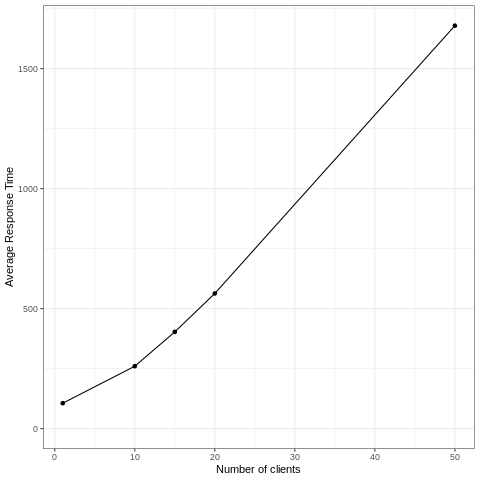

In [4]:
%%R -i out

out %>% filter(Name == "Aggregated") %>%
ggplot(aes(users, `Average Response Time`)) + geom_point() + geom_line() +
    xlab("Number of clients") + ylim(0, NA) + theme_bw()

Plot the same information, but calculating the average response time from full history data.

Also, plot response times (per second) for each sensor.

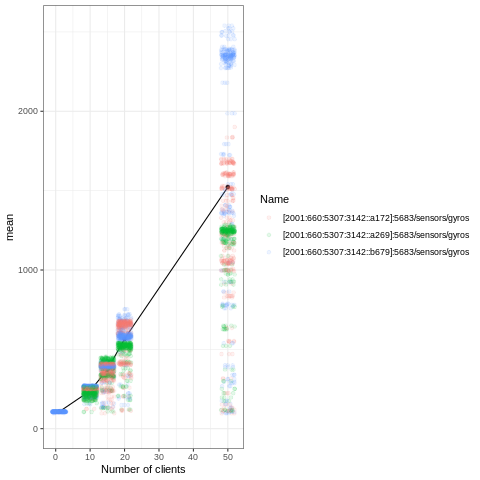

In [5]:
%%R -i out_full

out_full %>% filter(Name != "Aggregated") %>% group_by(users) %>% filter(`User Count` == users) %>% summarize(mean = mean(`Total Average Response Time`)) %>%
ggplot(aes(users, mean)) + geom_point() + geom_line() +
    geom_jitter(data=out_full[out_full$Name != "Aggregated",], aes(users, `Total Average Response Time`, color=Name), alpha=.1) +
    xlab("Number of clients") + ylim(0, NA) + theme_bw()

Plot response time evolution over time, considering the different load (number of clients).

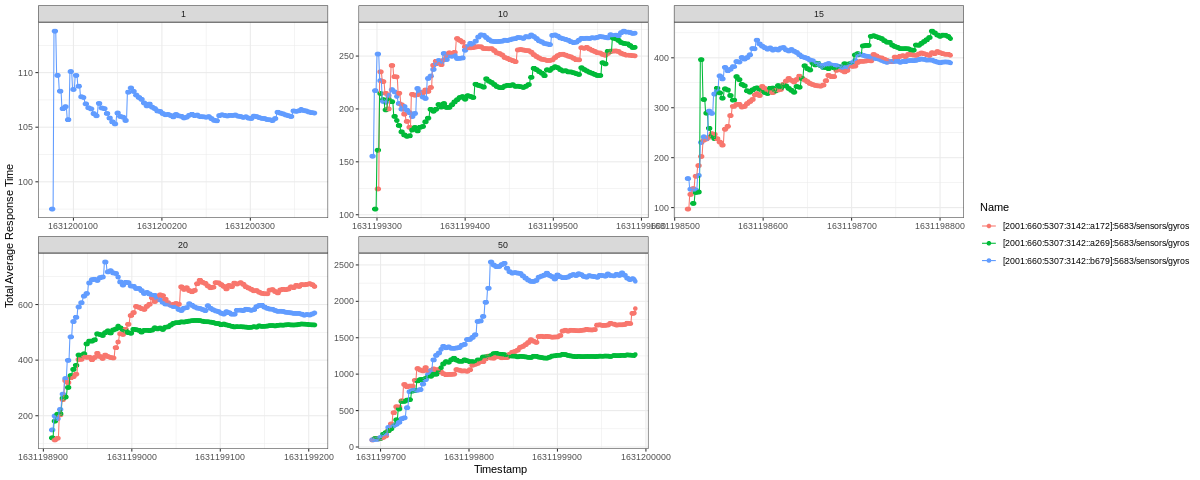

In [6]:
%%R -i out_full -w 1200
out_full %>% filter(Name!="Aggregated") %>% ggplot(aes(Timestamp, `Total Average Response Time`, color=Name)) + geom_point() + geom_line() +
    facet_wrap(~users, scales="free") + theme_bw()

We use the following nodes in our experiment:

```
m3-15.grenoble.iot-lab.info	Alive	m3 (at86rf231)	grenoble		c280	29.35	26.76	-0.04
m3-16.grenoble.iot-lab.info	Alive	m3 (at86rf231)	grenoble		a269	29.95	26.76	-0.04
m3-17.grenoble.iot-lab.info	Alive	m3 (at86rf231)	grenoble		a172	30.55	26.76	-0.04
m3-18.grenoble.iot-lab.info	Alive	m3 (at86rf231)	grenoble		b679	31.15	26.76	-0.04
```

The sensor m3-15 is our border router.

The sensor m3-16 (green, id a269) is the closest to the border router and it seems to have the best response time.

It seems that the response time is related to the distance of the border router. **At least when the system is overloaded**.

### Response time ($R$) against $\lambda$

Locust gives the $\lambda$, i.e. the number of request/s.

Let's plot it versus the response time.

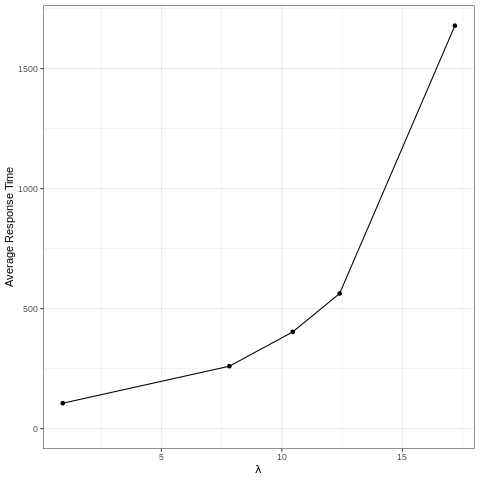

In [7]:
%%R -i out -i out_full

out %>% filter(Name == "Aggregated") %>%
ggplot(aes(`Requests/s`, `Average Response Time`)) + geom_point() + geom_line() +
    xlab(expression(lambda)) + ylim(0, NA) + theme_bw()

This $\lambda$ is calculated by locust and we don't know exactly how.

We can plot it over time to see how it evolves (for 50 clients).

`summarise()` has grouped output by 'users'. You can override using the `.groups` argument.


R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



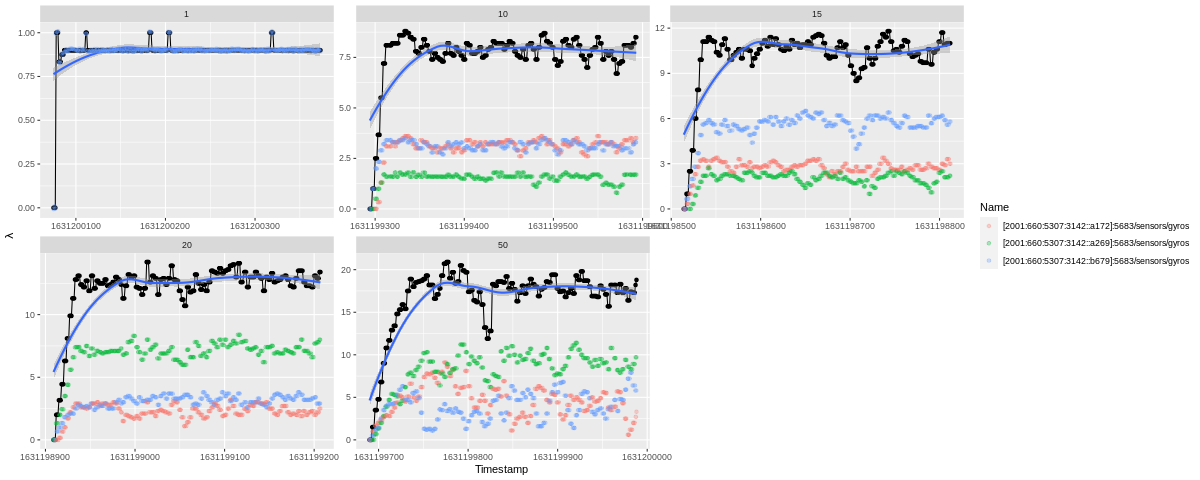

In [8]:
%%R -i out_full -w 1200

out_full %>% filter(Name != "Aggregated") %>% group_by(users, Timestamp) %>% summarize(lambda=sum(`Requests/s`)) %>%
    ggplot(aes(Timestamp, lambda)) + geom_point() + geom_line() + geom_smooth() +
    geom_jitter(data=out_full[out_full$Name != "Aggregated",], aes(Timestamp, `Requests/s`, color=Name), alpha=.3) +
    ylab(expression(lambda)) + facet_wrap(~users, scale="free")

As for the response time, the $\lambda$ seems related to the distance to the border router (for overloaded system).

### $1/R$ against $\lambda$

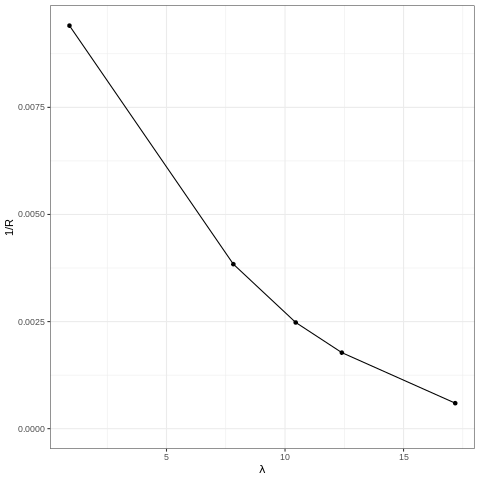

In [9]:
%%R -i out

out %>% filter(Name == "Aggregated") %>%
ggplot(aes(`Requests/s`, 1/`Average Response Time`)) + geom_point() + geom_line() +
    ylab(expression("1/R")) + xlab(expression(lambda)) + ylim(0, NA) + theme_bw()